# Plotting Functions

In [1]:
from pathlib import Path
import sys
sys.path.append('../src/rate')
from constants import SCORED_DIR
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import numpy as np
from treatment_effects import treatment_effects_pipeline
from utils_plotting import create_latex_tables_from_samples, plot_scores, naive_vs_RATE, rewrite_bias, synthetic_subplots, att_atu
from utils import load_dataset_from_json, write_to_json
import warnings
warnings.filterwarnings('ignore')

2025-01-18 18:08:00,365 - INFO - Note: NumExpr detected 32 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 16.
2025-01-18 18:08:00,366 - INFO - NumExpr defaulting to 16 threads.


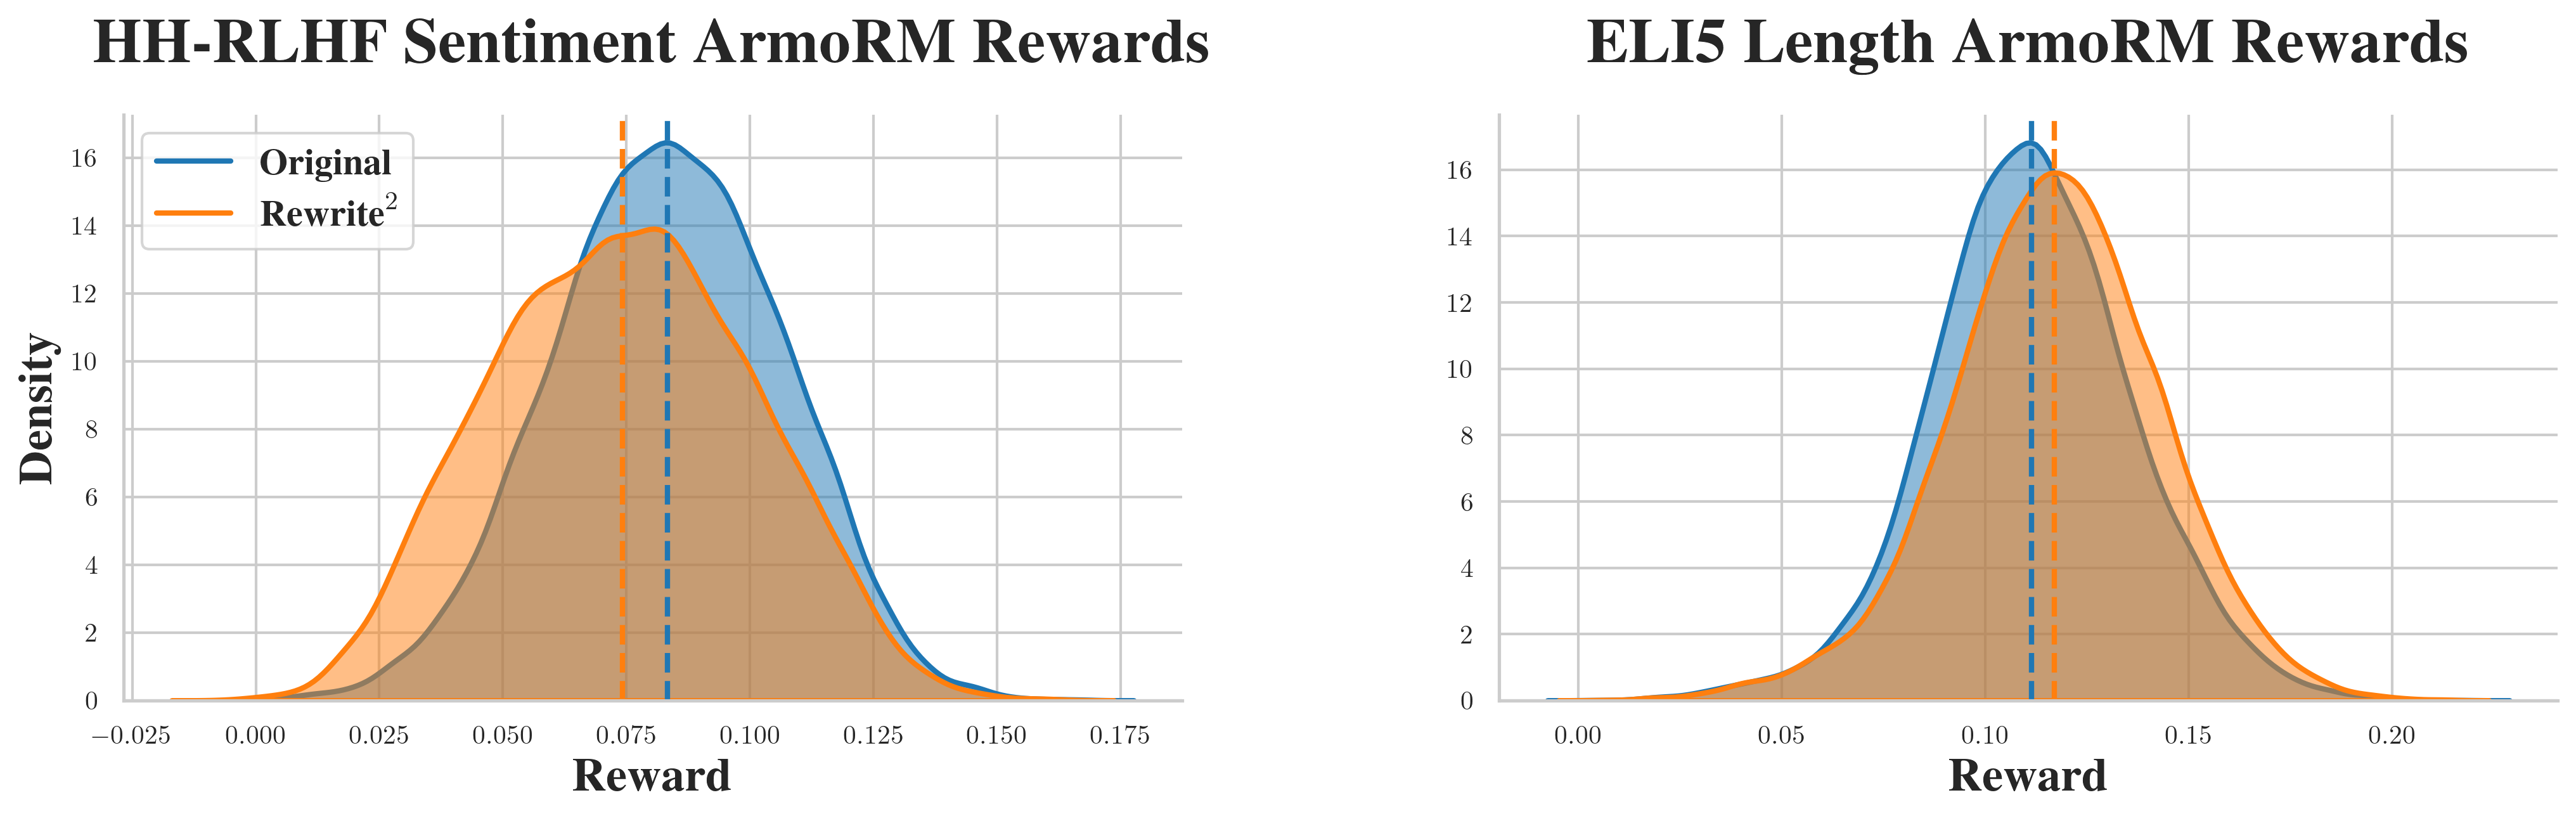

In [2]:
hh_rlhf_template = {
        "dataset_name": "HH-RLHF",
        "concept": "Sentiment",
        "score": "ArmoRM",
        "reward_key": "RLHFlow/ArmoRM-Llama3-8B-v0.1",
        "dataset_filename": "hh_rlhf_sentiment_scored_complete.jsonl"
    }
eli5_template = {
        "dataset_name": "ELI5",
        "concept": "Length",
        "score": "ArmoRM",
        "reward_key": "ArmoRM",
        "dataset_filename": "eli5_length_complete_scored_20240919_170111.jsonl"
    }

templates = [hh_rlhf_template, eli5_template]
plot_scores(templates, SCORED_DIR)

In [3]:
# load the json file
data_dir = Path("/net/projects/veitch/prompt_distributions/data/scored")
complete_dir = data_dir / "complete"

eli5_length = load_dataset_from_json(complete_dir / "eli5_length_complete_scored_20240919_170111.jsonl")
helpsteer_complexity = load_dataset_from_json(complete_dir / "helpsteer_complexity_complete_scored.jsonl")
helpsteer_helpfulness = load_dataset_from_json(complete_dir / "helpsteer_helpfulness_complete_scored.jsonl")
hh_rlhf_sentiment = load_dataset_from_json(complete_dir / "hh_rlhf_sentiment_scored_complete.jsonl")
imdb_length = load_dataset_from_json(complete_dir / "imdb_length_complete_scored_20240921_172425.jsonl")
imdb_sentiment = load_dataset_from_json(complete_dir / "imdb_sentiment_complete_scored_20240919_152739.jsonl")

In [4]:
# concatenate the length and sentiment datasets
def concat_datasets(dataset_A, dataset_B):
    # create temp keys for each dataset
    new_dataset_A = {f"A_{key}": value for key, value in dataset_A.items()}
    new_dataset_B = {f"B_{key}": value for key, value in dataset_B.items()}
    # concatenate the two dictionaries
    concatenated_dataset = {**new_dataset_A, **new_dataset_B}
    return concatenated_dataset

# some datasets have d["0"]["RLHFlow/ArmoRM-Llama3-8B-v0.1"] and others d["0"]["ArmoRM"], standardize to the former.
def standardize_ArmoRM(dataset):
    new_dataset = {}
    for key, value in dataset.items():
        # Check if "ArmoRM" exists as a key in the current level of the dictionary
        if "ArmoRM" in value:
            value["RLHFlow/ArmoRM-Llama3-8B-v0.1"] = value.pop("ArmoRM")
        new_dataset[key] = value
    return new_dataset

length = standardize_ArmoRM(concat_datasets(imdb_length, eli5_length))
complexity = standardize_ArmoRM(helpsteer_complexity)
helpfulness = standardize_ArmoRM(helpsteer_helpfulness)
sentiment = standardize_ArmoRM(concat_datasets(imdb_sentiment, hh_rlhf_sentiment))

In [ ]:
CONCEPTS = {
    "length": length,
    "complexity": complexity,
    "helpfulness": helpfulness,
    "sentiment": sentiment,
}

REWARD_MODELS = [
    "RLHFlow/ArmoRM-Llama3-8B-v0.1",
    "NCSOFT/Llama-3-OffsetBias-RM-8B",
    "sfairXC/FsfairX-LLaMA3-RM-v0.1",
]

all_data = []
all_templates = []

for concept, dataset in CONCEPTS.items():
    for rm_key in REWARD_MODELS:
        # We set up a minimal template that the pipeline function expects
        # (the pipeline uses e.g. reward_key, original=..., rewrite=..., etc.)
        effects_template = {
            "reward_key": rm_key,
            "w_original_key": "original",
            "w_counterfactual_key": "rewrite",
            "w_rewritten_rewrite_key": "rewritten rewrite",
            "dataset_name": "combined",  # or something descriptive
            "concept": concept,
            "score": rm_key,            # fill in so we know which model
        }

        # Now compute the effects for the entire combined dataset with that reward key
        effects = treatment_effects_pipeline(dataset, **effects_template)

        # Add the concept, model name, etc. so it’s easy to track
        # (the pipeline might already be returning some of this, but just to be sure)
        effects["concept"] = concept
        effects["score"] = rm_key

        all_data.append(effects)
        all_templates.append(effects_template)


=== Model: RLHFlow/ArmoRM-Llama3-8B-v0.1 ===
Concept: complexity           | Naive: 0.325 ± 0.020 | RATE: 0.152 ± 0.011
Concept: helpfulness          | Naive: 1.036 ± 0.015 | RATE: 0.308 ± 0.011
Concept: length               | Naive: 0.337 ± 0.009 | RATE: -0.013 ± 0.006
Concept: sentiment            | Naive: 0.484 ± 0.009 | RATE: 0.644 ± 0.007

=== Model: NCSOFT/Llama-3-OffsetBias-RM-8B ===
Concept: complexity           | Naive: 0.273 ± 0.020 | RATE: -0.324 ± 0.011
Concept: helpfulness          | Naive: 1.202 ± 0.015 | RATE: 0.161 ± 0.010
Concept: length               | Naive: 0.338 ± 0.009 | RATE: 0.099 ± 0.008
Concept: sentiment            | Naive: 0.365 ± 0.009 | RATE: 0.509 ± 0.007

=== Model: sfairXC/FsfairX-LLaMA3-RM-v0.1 ===
Concept: complexity           | Naive: 0.488 ± 0.020 | RATE: 0.325 ± 0.011
Concept: helpfulness          | Naive: 1.253 ± 0.016 | RATE: 0.393 ± 0.010
Concept: length               | Naive: 0.992 ± 0.009 | RATE: 0.292 ± 0.008
Concept: sentiment            | 

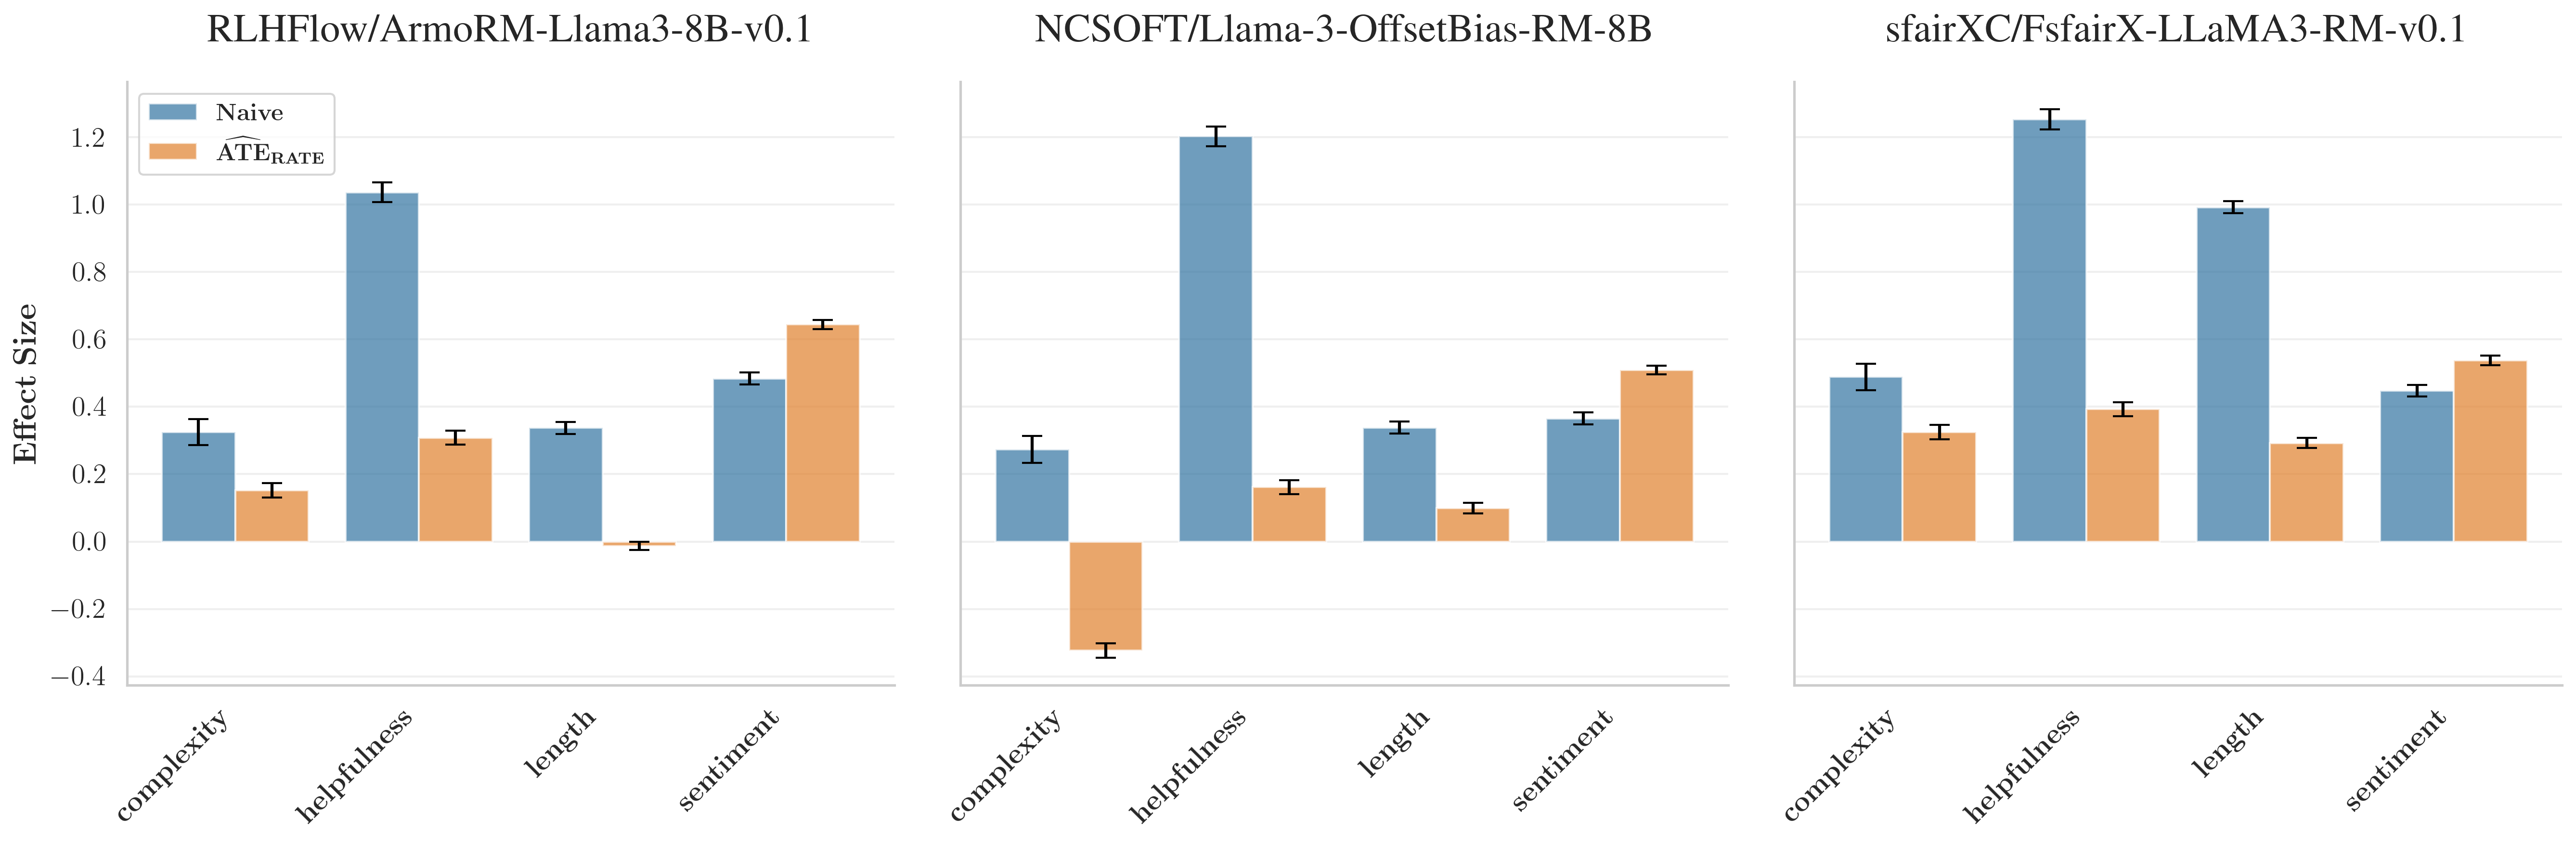

In [6]:
naive_vs_RATE(
    all_data=all_data,
    all_templates=all_templates,
    reward_models=REWARD_MODELS,
    normalize=True
)

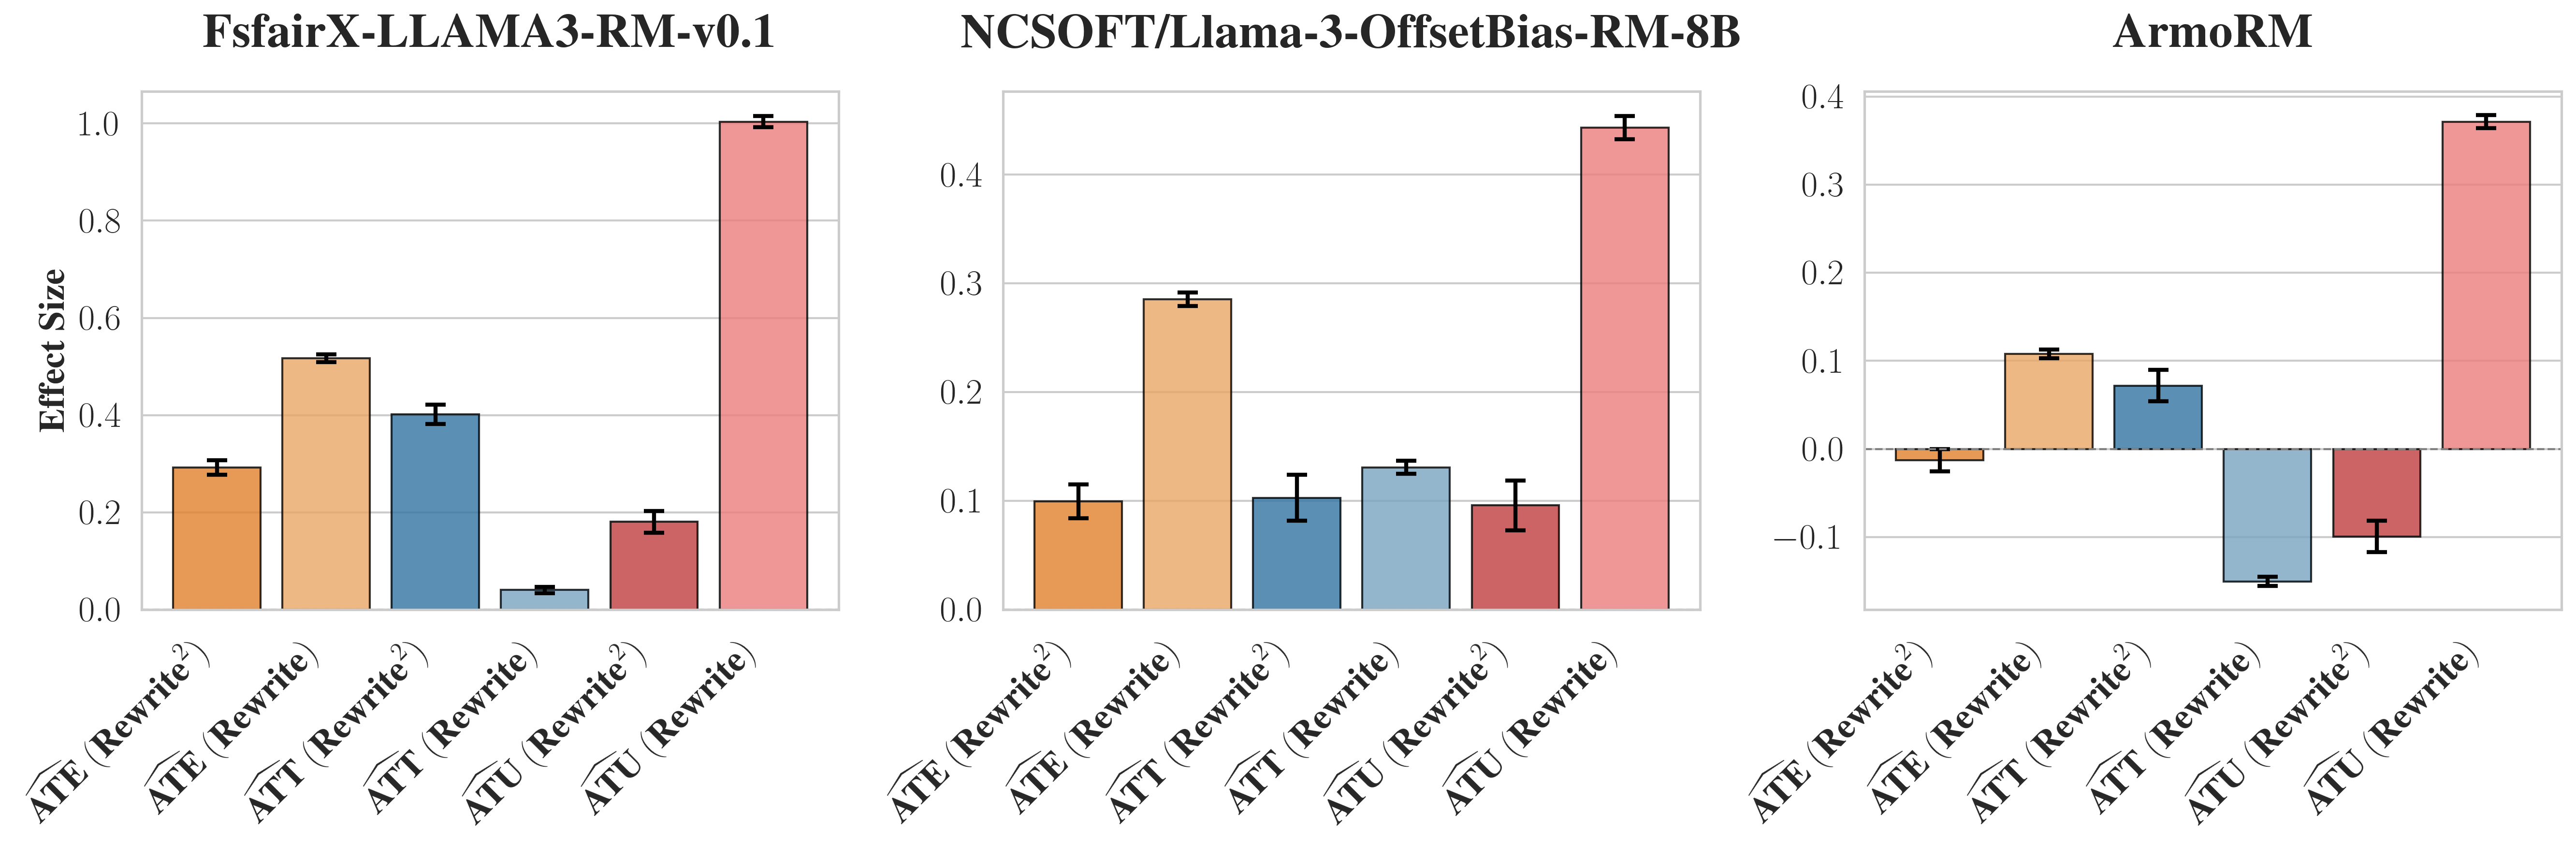

In [7]:
# reverse effects_data[0:3]
reversed_data = all_data[0:3][::-1]

# Titles for each subplot
titles = [
    "FsfairX-LLAMA3-RM-v0.1",
    "NCSOFT/Llama-3-OffsetBias-RM-8B",
    "ArmoRM"
]
rewrite_bias(reversed_data, titles)

In [8]:
config = load_dataset_from_json(Path("config_plotting_synth.jsonl"))

# make into list of dictionaries
synthetic_templates = [value for value in config.values()]

In [9]:
# save all the data
synthetic_data = []
for effects_template in synthetic_templates:
    dataset_filename = effects_template["dataset_filename"]
    dataset_filename = Path(dataset_filename)
    dataset = load_dataset_from_json(SCORED_DIR / "synthetic" / "positive_long" / dataset_filename)
    effects = treatment_effects_pipeline(dataset, **effects_template)
    synthetic_data.append(effects)

2025-01-18 18:08:20,745 - INFO - Number of w=1 examples: 4004
2025-01-18 18:08:20,753 - INFO - Number of w=0 examples: 5372
2025-01-18 18:08:20,764 - INFO - Treatment effects: {   'ATE_rewritten_rewrite': 0.0844035465969567,
    'ATE_rewritten_rewrite_stderr': 0.04930379836414409,
    'ATE_single_rewrite': 0.16884899790376523,
    'ATE_single_rewrite_stderr': 0.01354892736882799,
    'ATT_rewritten_rewrite': 0.2384955123230651,
    'ATT_rewritten_rewrite_stderr': 0.06947906261246611,
    'ATT_single_rewrite': -0.330754465871043,
    'ATT_single_rewrite_stderr': 0.01630709816868453,
    'ATU_rewritten_rewrite': -0.0304483206344911,
    'ATU_rewritten_rewrite_stderr': 0.0685568950220651,
    'ATU_single_rewrite': 0.5412265610002531,
    'ATU_single_rewrite_stderr': 0.01873701381382012,
    'Y0_count': 5372,
    'Y1_count': 4004,
    'naive_effect': -0.2572232905938362,
    'naive_effect_stderr': 0.06290409599455854,
    'reward_std': 3.068588378397191}
2025-01-18 18:08:20,768 - INFO - Ca

In [10]:
config = load_dataset_from_json(Path("config_plotting_help_synth.jsonl"))

# make into list of dictionaries
help_synthetic_templates = [value for value in config.values()]

In [11]:
# save all the data
help_synthetic_data = []
for effects_template in help_synthetic_templates:
    dataset_filename = effects_template["dataset_filename"]
    dataset_filename = Path(dataset_filename)
    dataset = load_dataset_from_json(SCORED_DIR / "synthetic_helpsteer" / dataset_filename)
    effects = treatment_effects_pipeline(dataset, **effects_template)
    help_synthetic_data.append(effects)

2025-01-18 18:08:24,861 - INFO - Number of w=1 examples: 2574
2025-01-18 18:08:24,884 - INFO - Number of w=0 examples: 2574
2025-01-18 18:08:24,902 - INFO - Treatment effects: {   'ATE_rewritten_rewrite': 0.014393984818637143,
    'ATE_rewritten_rewrite_stderr': 0.00079378864033712,
    'ATE_single_rewrite': 0.01957111698185457,
    'ATE_single_rewrite_stderr': 0.0005043422673346951,
    'ATT_rewritten_rewrite': 0.0054083771461102825,
    'ATT_rewritten_rewrite_stderr': 0.0011309362696518663,
    'ATT_single_rewrite': 0.04116395636899113,
    'ATT_single_rewrite_stderr': 0.0006486281561102675,
    'ATU_rewritten_rewrite': 0.02337959249116403,
    'ATU_rewritten_rewrite_stderr': 0.0010911649065769267,
    'ATU_single_rewrite': -0.002021722405281992,
    'ATU_single_rewrite_stderr': 0.00048425794318990095,
    'Y0_count': 2574,
    'Y1_count': 2574,
    'naive_effect': 0.031895498183147755,
    'naive_effect_stderr': 0.000981691571743384,
    'reward_std': 0.03521797135263725}
2025-01-18

Slope of $\widehat{\textbf{ATE}}\ (\textbf{Rewrite}^2)$: 0.04676868149957367
Slope of $\widehat{\textbf{ATE}}\ (\textbf{Rewrite})$: -0.10007485133004765
Slope of $\widehat{\textbf{ATE}}\ (\textbf{Rewrite}^2)$: -0.011395818249528256
Slope of $\widehat{\textbf{ATE}}\ (\textbf{Rewrite})$: -0.041311543802865024


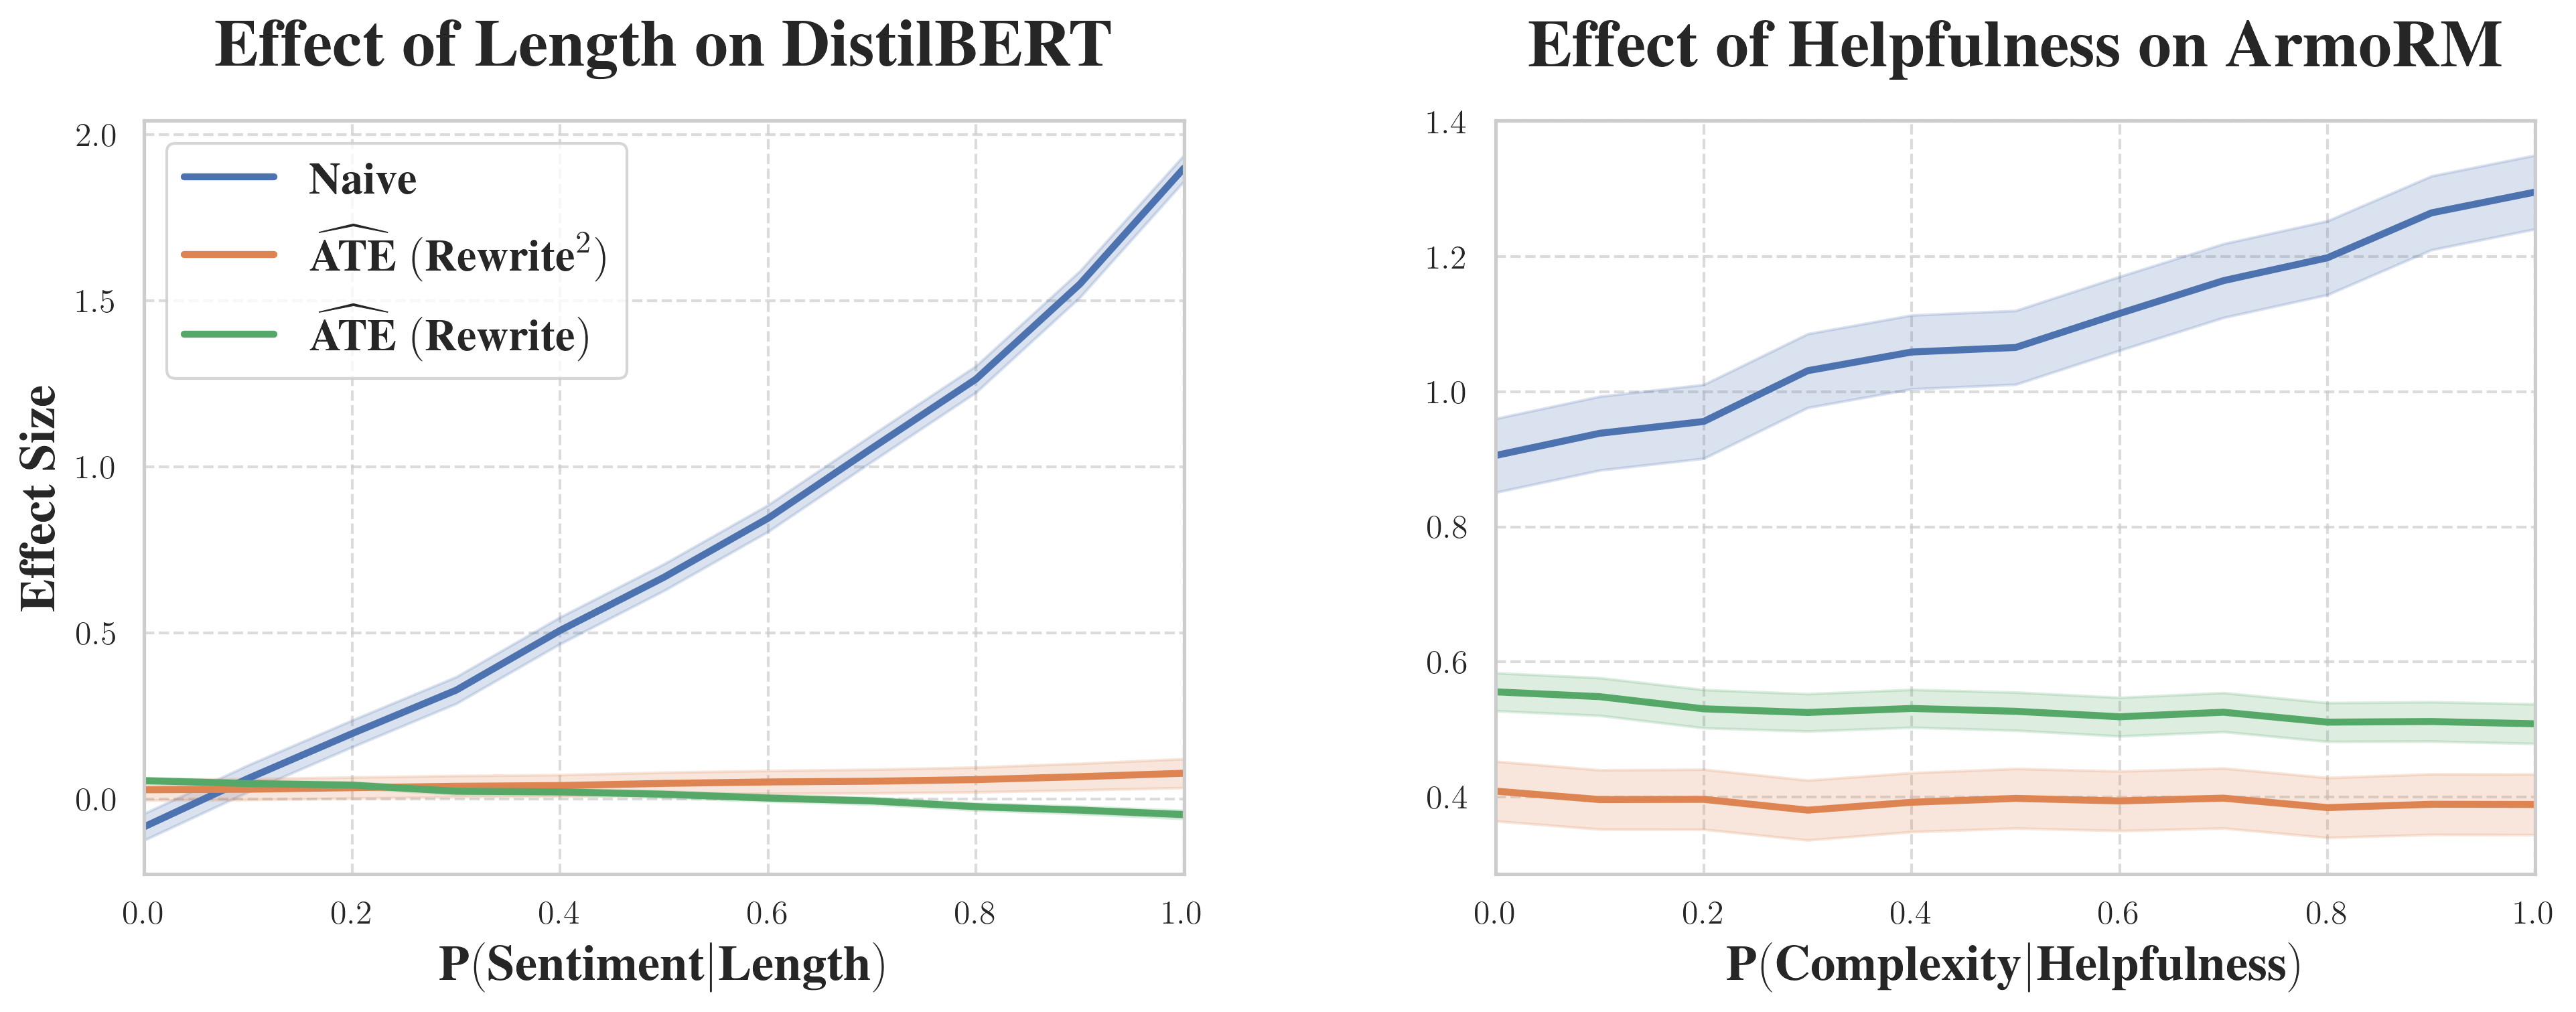

In [12]:
synthetic_subplots(synthetic_data, synthetic_templates, "Length", "Sentiment",
          help_synthetic_data, help_synthetic_templates, "Helpfulness", "Complexity")